# Step 4: Kawempe Grid-Based Risk Features and ML Exploration

This notebook creates a uniform grid over Kawempe, computes per-cell urban risk indicators (NDVI, buildings, services, roads), and performs basic ML clustering.

In [25]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterstats import zonal_stats
from shapely.geometry import box
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Define Grid Area

<Axes: >

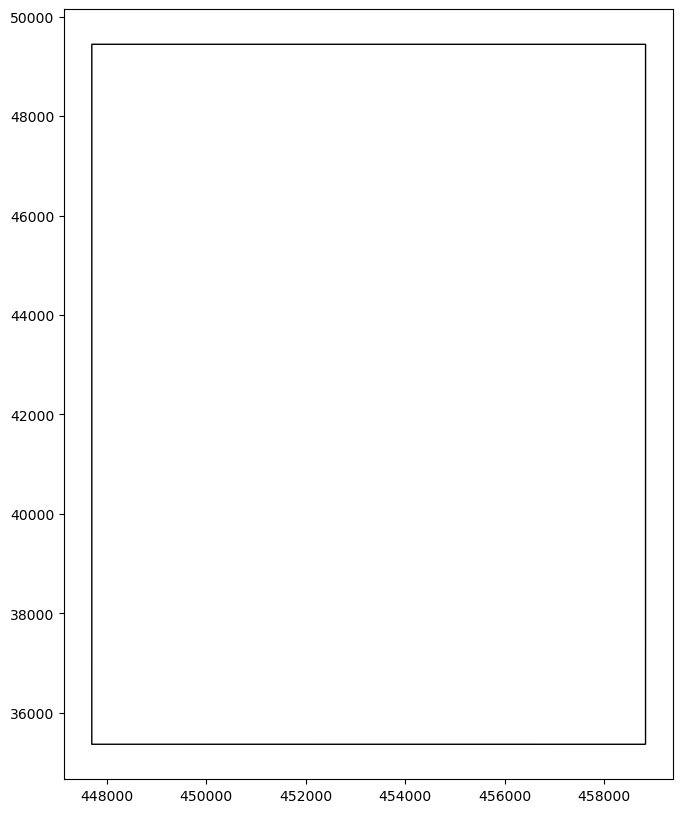

In [26]:
from shapely.geometry import box

# NDVI path
ndvi_path = "../data/raw/Kawempe_NDVI_2023.tif"

with rasterio.open(ndvi_path) as src:
    raster_bounds = src.bounds
    raster_crs = src.crs

# Load and reproject OSM layers to NDVI CRS
buildings = gpd.read_file("../data/raw/kawempe_buildings.geojson")
roads = gpd.read_file("../data/raw/kawempe_roads.geojson")
services = gpd.read_file("../data/raw/kawempe_services.geojson")

# Reproject all to match raster CRS
buildings = buildings.to_crs(raster_crs)
roads = roads.to_crs(raster_crs)
services = services.to_crs(raster_crs)

# Get total bounds from all layers
b_all = buildings.total_bounds
r_all = roads.total_bounds
s_all = services.total_bounds

# Combine bounds into one larger extent
xmin = min(raster_bounds.left, b_all[0], r_all[0], s_all[0])
ymin = min(raster_bounds.bottom, b_all[1], r_all[1], s_all[1])
xmax = max(raster_bounds.right, b_all[2], r_all[2], s_all[2])
ymax = max(raster_bounds.top, b_all[3], r_all[3], s_all[3])

# Create a bounding box
bbox = box(xmin, ymin, xmax, ymax)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs=raster_crs).to_crs("EPSG:32636")

# Plot to confirm
bbox_gdf.plot(edgecolor='black', facecolor='none', figsize=(10, 10))


## Create Uniform Grid

Generated 35 grid cells of size 2000m × 2000m


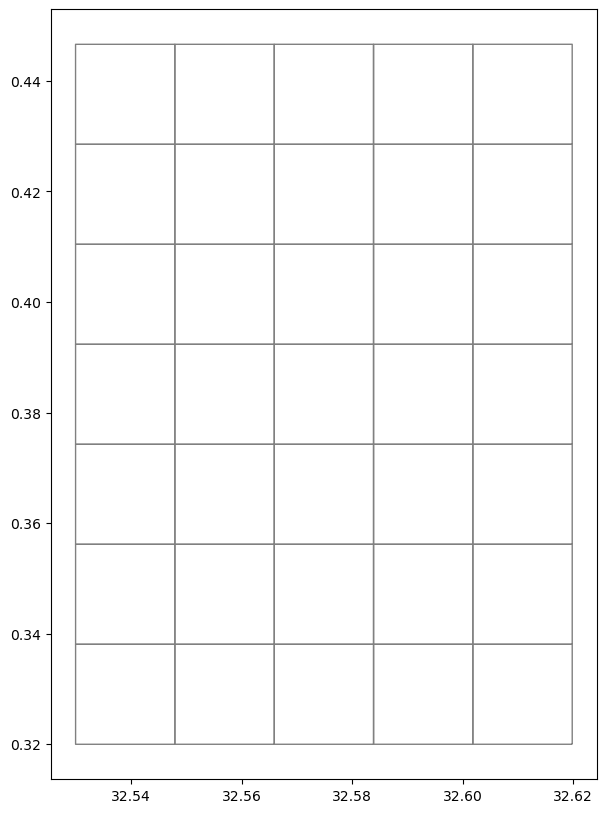

In [27]:
grid_size = 2000 # 2 km
xmin, ymin, xmax, ymax = bbox_gdf.total_bounds
rows = int((ymax - ymin) / grid_size)
cols = int((xmax - xmin) / grid_size)
grid_cells = [box(xmin + i * grid_size, ymin + j * grid_size,
                  xmin + (i + 1) * grid_size, ymin + (j + 1) * grid_size)
              for i in range(cols) for j in range(rows)]
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs='EPSG:32636').to_crs('EPSG:4326')
grid.plot(edgecolor='gray', facecolor='none', figsize=(10, 10))

print(f"Generated {len(grid)} grid cells of size {grid_size}m × {grid_size}m")


## Compute NDVI per Grid Cell

In [28]:
stats = zonal_stats(grid.to_json(), ndvi_path, stats=['mean'], geojson_out=True)
ndvi_grid = gpd.GeoDataFrame.from_features(stats).set_crs('EPSG:4326')
ndvi_grid = ndvi_grid.rename(columns={'mean': 'mean_ndvi'})
print(ndvi_grid.count())
ndvi_grid.head()

geometry     35
mean_ndvi    35
dtype: int64


,geometry,mean_ndvi
0,"POLYGON ((32.54795 0.31998, 32.54795 0.33807, ...",0.167570
1,"POLYGON ((32.54795 0.33807, 32.54794 0.35616, ...",0.213353
2,"POLYGON ((32.54794 0.35616, 32.54794 0.37426, ...",0.168311
3,"POLYGON ((32.54794 0.37426, 32.54794 0.39235, ...",0.055386
4,"POLYGON ((32.54794 0.39235, 32.54794 0.41045, ...",0.000000


## Histogram and Boxplot of NDVI

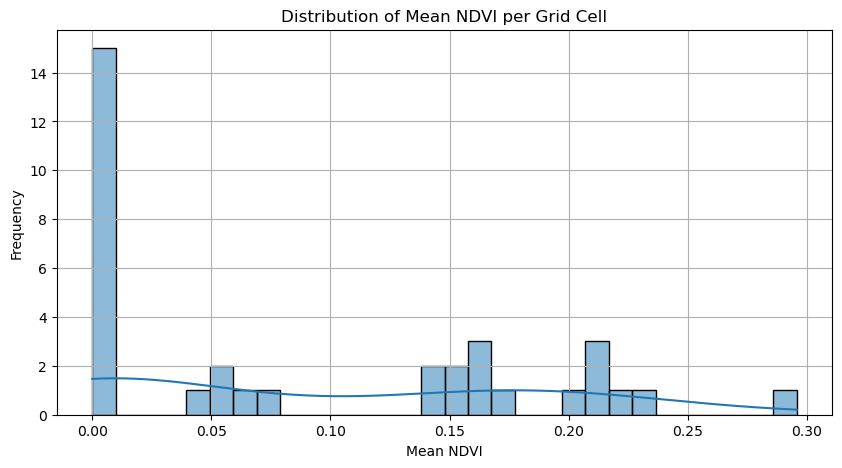

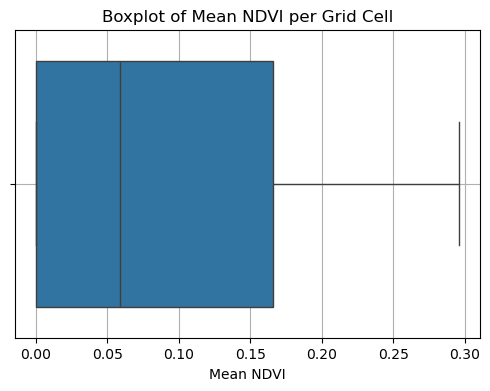

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop NaNs for clean plots
ndvi_vals = ndvi_grid['mean_ndvi'].dropna()

# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(ndvi_vals, bins=30, kde=True)
plt.title("Distribution of Mean NDVI per Grid Cell")
plt.xlabel("Mean NDVI")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=ndvi_vals)
plt.title("Boxplot of Mean NDVI per Grid Cell")
plt.xlabel("Mean NDVI")
plt.grid(True)
plt.show()


## Spatial Map to Spot Anomalies

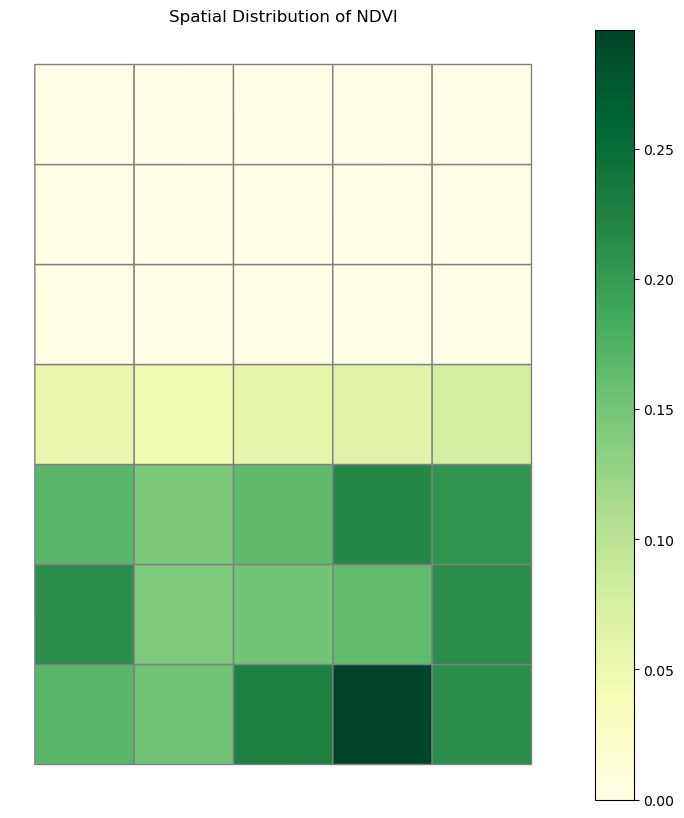

In [30]:
ndvi_grid.plot(column='mean_ndvi', cmap='YlGn', legend=True, figsize=(10, 10), edgecolor='gray')
plt.title("Spatial Distribution of NDVI")
plt.axis('off')
plt.show()

In [31]:
# Sanity check

print("Grid cells with valid NDVI:", ndvi_grid['mean_ndvi'].notna().sum())
print("Grid cells without NDVI:", ndvi_grid['mean_ndvi'].isna().sum())

Grid cells with valid NDVI: 35
Grid cells without NDVI: 0


# Combine Features

## ✅ Ready to combine all features and compute the final risk score

At this stage, all spatial features — including NDVI, infrastructure, and population — have been extracted and aligned to the grid. The data is cleaned and preprocessed, so we are now ready to design and compute the **Urban Vulnerability Score** for each grid cell based on these inputs.


## Count Features per Grid Cell and Show Plot

In [35]:
# Create urban_grid from ndvi_grid
urban_grid = ndvi_grid.copy()

# --- Add Features ---

# Building count
bldg_join = gpd.sjoin(buildings, urban_grid, predicate='within')
bldg_count = bldg_join.groupby(bldg_join.index_right).size()
urban_grid['building_count'] = urban_grid.index.map(bldg_count).fillna(0)

# Service count
svc_join = gpd.sjoin(services, urban_grid, predicate='within')
svc_count = svc_join.groupby(svc_join.index_right).size()
urban_grid['service_count'] = urban_grid.index.map(svc_count).fillna(0)

# Road length
roads_proj = roads.to_crs('EPSG:32636')
roads_proj['length_km'] = roads_proj.length / 1000
grid_proj = urban_grid.to_crs('EPSG:32636')
road_join = gpd.sjoin(roads_proj, grid_proj, predicate='within')
road_length = road_join.groupby(road_join.index_right)['length_km'].sum()
urban_grid['road_km'] = urban_grid.index.map(road_length).fillna(0)

# Population (join + cleanup)
pop_data = gpd.read_file("../data/processed/kawempe_grid_with_population.geojson")
urban_grid = gpd.sjoin(urban_grid, pop_data[["geometry", "pop_est"]], predicate="intersects", how="left")
urban_grid = urban_grid.drop(columns=[col for col in urban_grid.columns if col.startswith("index_")])
urban_grid["pop_est"] = urban_grid["pop_est"].fillna(0).astype(int)

# --- NDVI flattening and scaling ---
def flatten_ndvi(ndvi_series, threshold=0.3):
    if ndvi_series.max() <= threshold:
        return pd.Series([0.5] * len(ndvi_series), index=ndvi_series.index)
    else:
        clipped = ndvi_series.clip(lower=threshold, upper=0.8)
        return (clipped - threshold) / (0.8 - threshold)

urban_grid['scaled_ndvi'] = flatten_ndvi(urban_grid['mean_ndvi'])
urban_grid['inv_ndvi'] = 1 - urban_grid['scaled_ndvi']

# Drop duplicates based on geometry
urban_grid = urban_grid.drop_duplicates(subset="geometry").reset_index(drop=True)


## Mask Low Activity Cells

In [7]:
# mask = (
#     (urban_grid["building_count"] < 500) &
#     (urban_grid["service_count"] < 10) &
#     (urban_grid["road_km"] < 10)
# )

# # Define small scaling weights
# w_b = 2      # each building = ~2 people
# w_s = 5      # each service = ~5 people
# w_r = 10     # each km of road = ~10 people

# # Assign small non-zero estimated population using weighted logic
# urban_grid.loc[mask, "pop_est"] = (
#     w_b * urban_grid["building_count"] +
#     w_s * urban_grid["service_count"] +
#     w_r * urban_grid["road_km"]
# )[mask].astype(int)


## Normalize Features

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Select and scale relevant features
features_to_scale = ['inv_ndvi', 'building_count', 'service_count', 'road_km', 'pop_est']

scaler = MinMaxScaler()
urban_grid[[f"{col}_scaled" for col in features_to_scale]] = scaler.fit_transform(
    urban_grid[features_to_scale]
)


In [37]:
# check scaled data
urban_grid[['inv_ndvi_scaled', 
            'building_count_scaled', 
            'service_count_scaled', 
            'road_km_scaled', 
            'pop_est_scaled']].describe()


,inv_ndvi_scaled,building_count_scaled,service_count_scaled,road_km_scaled,pop_est_scaled
count,35.0,35.000000,35.000000,35.000000,35.000000
mean,0.0,0.149504,0.131034,0.185576,0.447193
std,0.0,0.270770,0.274535,0.293274,0.264335
min,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.200434
50%,0.0,0.000000,0.000000,0.000000,0.558907
75%,0.0,0.158666,0.082759,0.302670,0.607081
max,0.0,1.000000,1.000000,1.000000,1.000000


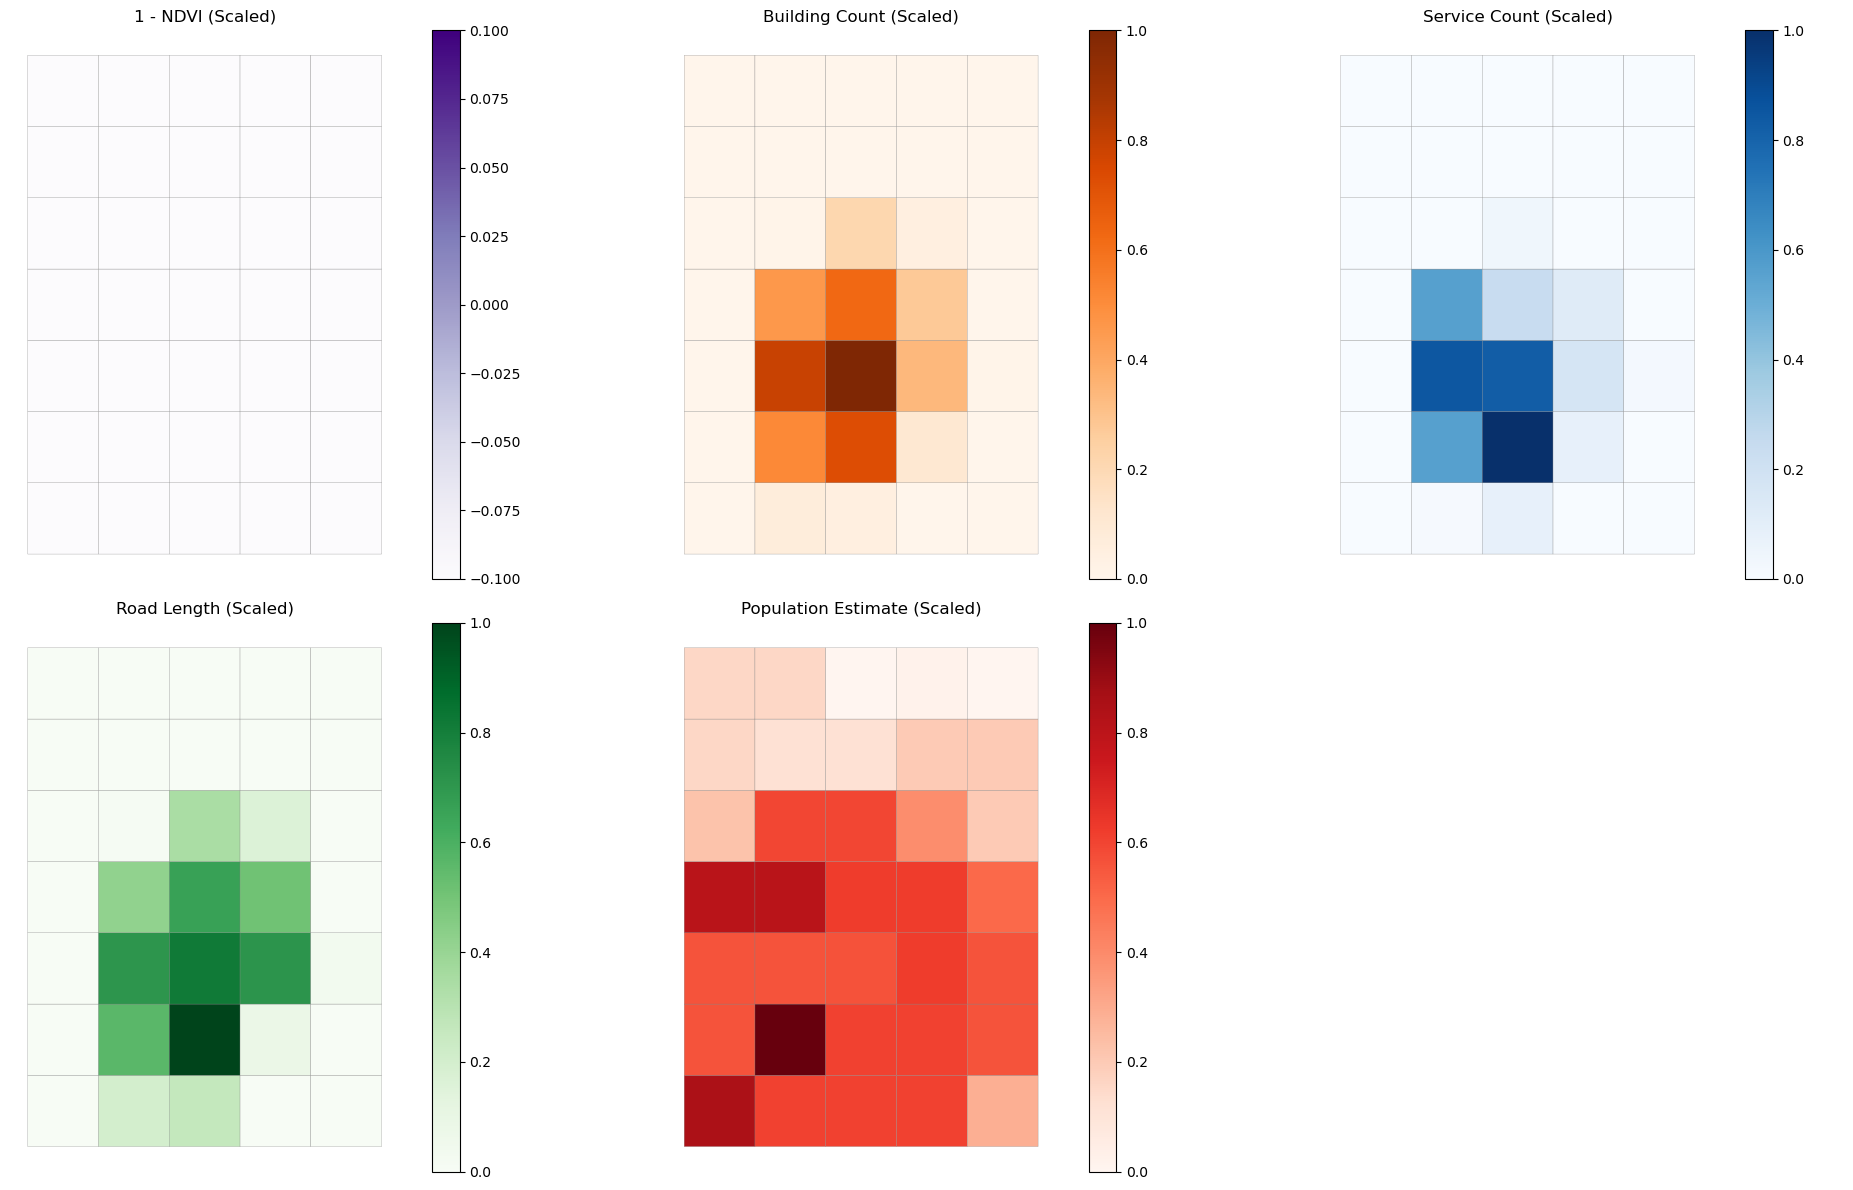

<Figure size 640x480 with 0 Axes>

In [54]:
# Plot features

scaled_cols = [f"{col}_scaled" for col in features_to_scale]

fig, axs = plt.subplots(2, 3, figsize=(20, 12))

titles = [
    "1 - NDVI (Scaled)",
    "Building Count (Scaled)",
    "Service Count (Scaled)",
    "Road Length (Scaled)",
    "Population Estimate (Scaled)"
]

cmaps = ["Purples", "Oranges", "Blues", "Greens", "Reds"]

for i, col in enumerate(scaled_cols):
    row = i // 3
    col_index = i % 3
    urban_grid.plot(
        column=col,
        cmap=cmaps[i],
        legend=True,
        edgecolor="gray",
        linewidth=0.2,
        ax=axs[row, col_index]
    )
    axs[row, col_index].set_title(titles[i])
    axs[row, col_index].axis("off")

# Hide unused sixth subplot
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

plt.savefig("../visualizations/features_map.png", dpi=300, bbox_inches='tight')


# Vulnerability Scores

## Vulnerability Score 1: “Hidden Vulnerability” (Low Infra + High Pop)

This score highlights pockets with high population but low infrastructure access, which may be overlooked in traditional risk models.

Components:
- pop_est_scaled → High is risky
- building_count_scaled, service_count_scaled, road_km_scaled → Low is risky

In [39]:
urban_grid['vuln_score_hidden'] = (
    urban_grid['pop_est_scaled'] *
    (1 - urban_grid['building_count_scaled']) *
    (1 - urban_grid['service_count_scaled']) *
    (1 - urban_grid['road_km_scaled'])
)


## Vulnerability Score 2: “Rescue Priority” (High Pop + High Infra)

This score is useful in disaster scenarios (e.g., earthquakes), where areas with both high population and dense infrastructure may need urgent response due to potential for large-scale impact.

Components:
- pop_est_scaled and all infra → High is risky


In [47]:
urban_grid['vuln_score_rescue'] = (
    0.4 * urban_grid['pop_est_scaled'] +
    0.2 * urban_grid['building_count_scaled'] +
    0.2 * urban_grid['service_count_scaled'] +
    0.2 * urban_grid['road_km_scaled']
)

## Visualize Scores

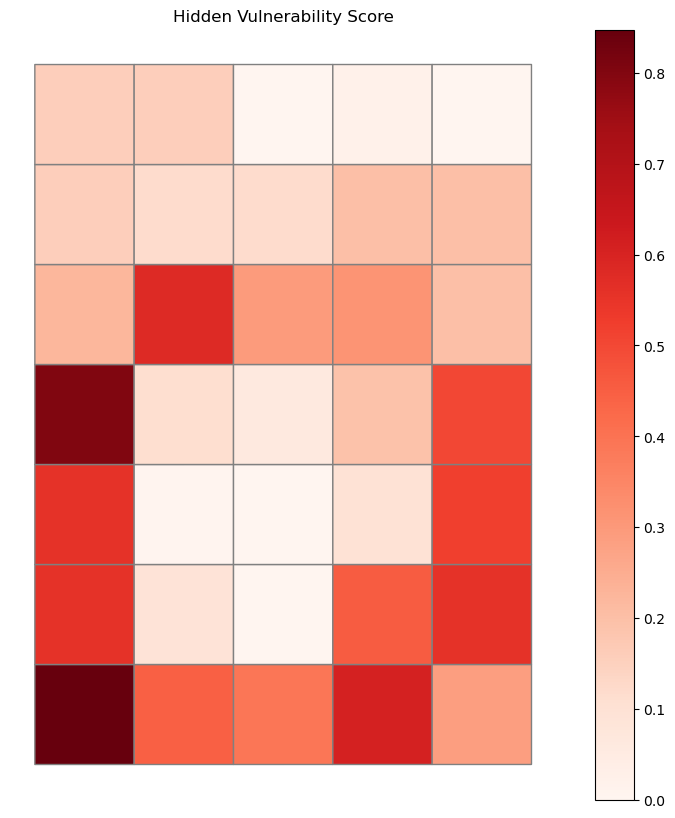

<Figure size 640x480 with 0 Axes>

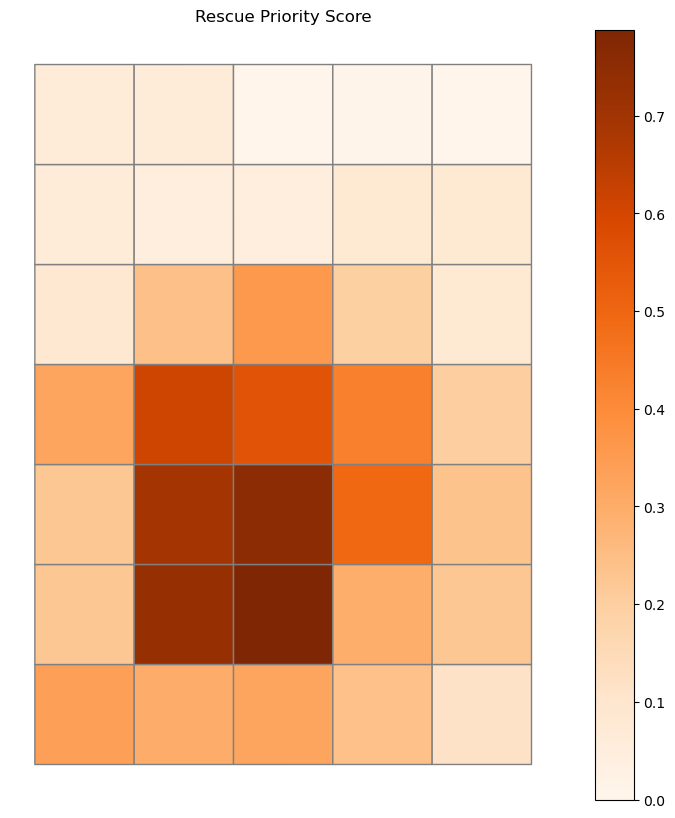

<Figure size 640x480 with 0 Axes>

In [53]:
urban_grid.plot(column='vuln_score_hidden', cmap='Reds', legend=True, figsize=(10, 10), edgecolor='gray')
plt.title("Hidden Vulnerability Score")
plt.axis('off')
plt.show()

plt.savefig("../visualizations/vuln_score_hidden_map.png", dpi=300, bbox_inches='tight')

urban_grid.plot(column='vuln_score_rescue', cmap='Oranges', legend=True, figsize=(10, 10), edgecolor='gray')
plt.title("Rescue Priority Score")
plt.axis('off')
plt.show()

plt.savefig("../visualizations/vuln_score_rescue_map.png", dpi=300, bbox_inches='tight')


# Vulnerability Classification

In this section, we compute multiple vulnerability scores based on scaled features such as population density, infrastructure access, and vegetation cover. These scores help identify:

- **Hidden Vulnerability**: Areas with high population and poor infrastructure
- **Rescue Priority**: Densely populated zones with heavy infrastructure, at risk during disasters

The resulting metrics guide targeted interventions, planning, and resource allocation.


In [49]:
# Define vulnerability score columns to classify
score_cols = ['vuln_score_hidden', 'vuln_score_rescue']

# Loop through each score and create a classified level column
for col in score_cols:
    # Apply qcut without labels to determine how many bins are valid
    bins = pd.qcut(urban_grid[col], q=4, duplicates='drop')
    n_bins = len(bins.cat.categories)
    
    # Map labels (adjust if fewer bins due to tied values)
    labels_map = ['Low', 'Medium', 'High', 'Very High'][:n_bins]
    
    # Create new column with classification labels
    level_col = f"{col}_level"
    urban_grid[level_col] = pd.qcut(
        urban_grid[col],
        q=4,
        labels=labels_map,
        duplicates='drop'
    )


## Visualize Vulnerability Levels

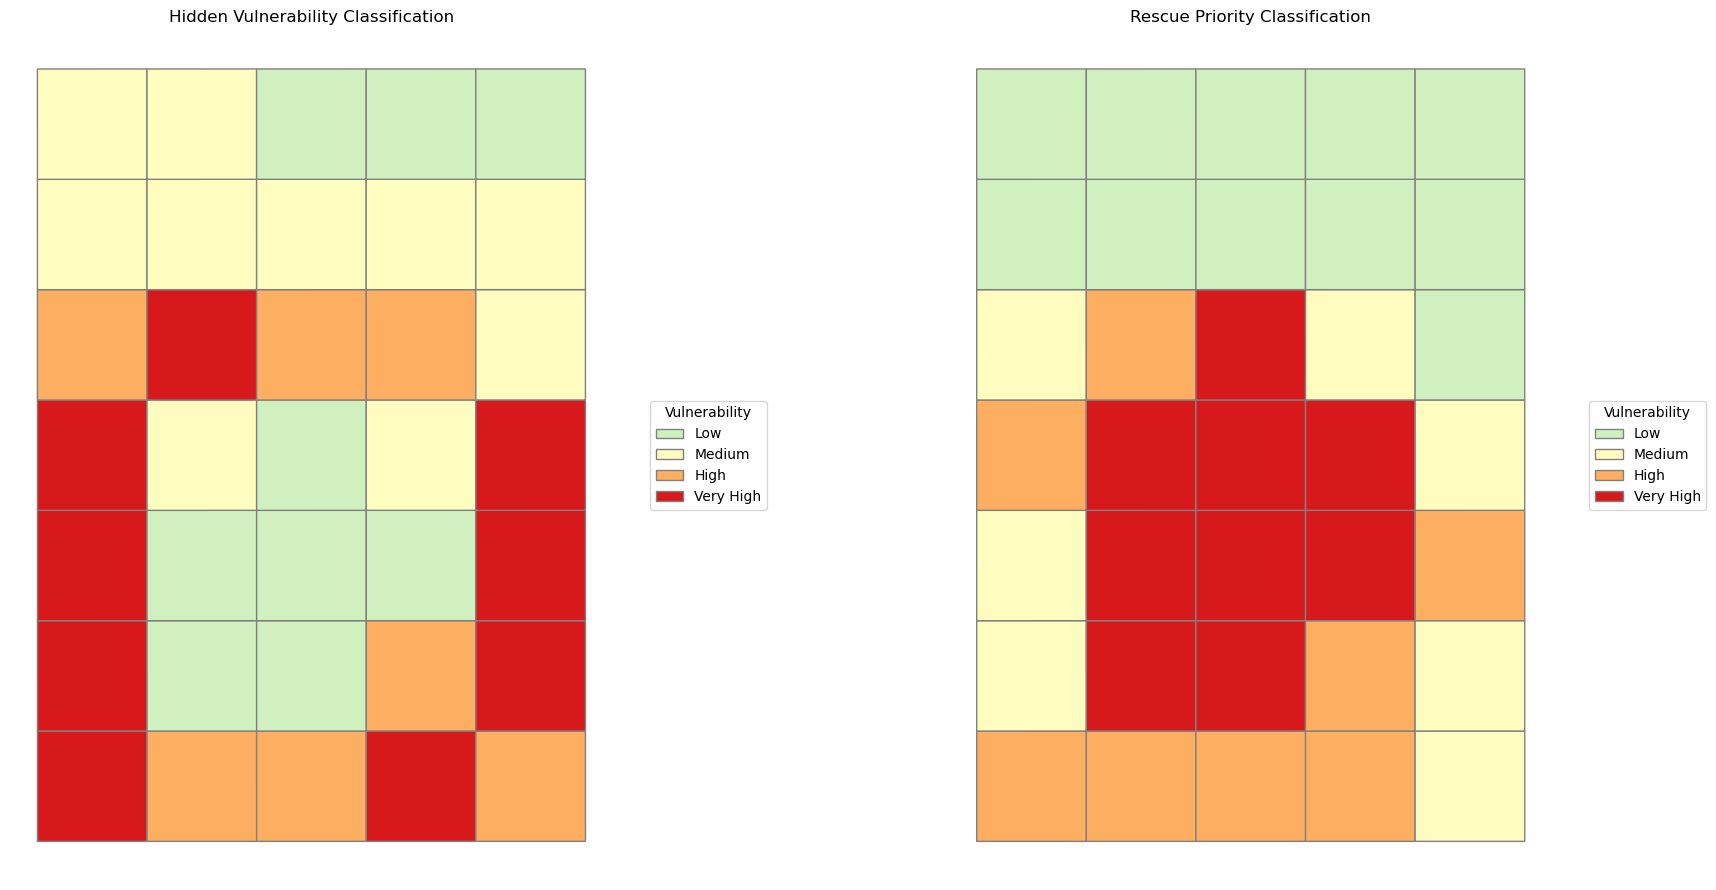

<Figure size 640x480 with 0 Axes>

In [52]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define levels and colors
labels_ordered = ['Low', 'Medium', 'High', 'Very High']
color_map = {
    'Low': '#d0f0c0',
    'Medium': '#fefcbf',
    'High': '#fdae61',
    'Very High': '#d7191c'
}
legend_elements = [Patch(facecolor=color_map[label], edgecolor='gray', label=label) for label in labels_ordered]

# Create plots with extra space on the right
fig, axes = plt.subplots(1, 2, figsize=(20, 9))  # wider to accommodate legends

# Hidden Vulnerability
urban_grid.plot(
    ax=axes[0],
    edgecolor='gray',
    color=urban_grid['vuln_score_hidden_level'].map(color_map)
)

axes[0].set_title("Hidden Vulnerability Classification")
axes[0].axis('off')
axes[0].legend(
    handles=legend_elements,
    title="Vulnerability",
    loc='center left',
    bbox_to_anchor=(1.05, 0.5)
)

# Rescue Priority
urban_grid.plot(
    ax=axes[1],
    edgecolor='gray',
    color=urban_grid['vuln_score_rescue_level'].map(color_map)
)

axes[1].set_title("Rescue Priority Classification")
axes[1].axis('off')
axes[1].legend(
    handles=legend_elements,
    title="Vulnerability",
    loc='center left',
    bbox_to_anchor=(1.05, 0.5)
)

plt.tight_layout()
plt.show()

plt.savefig("../visualizations/vulnerability_classification_map.png", dpi=300, bbox_inches='tight')